## Comparison of performance of XGBoost, Recurrent Neural Network and Prophet  framework on a time serie

Made by: Amylkar Urrea Montoya. email:amylkar.urrea@udea.edu.co

The objective of this work is to do a comparison of performance of several non-traditional methods to model time series. In this case, I used this [data](https://www.kaggle.com/robikscube/hourly-energy-consumption), which is available on kaggle. The data set is about the hourly power consumption in Mega Watts of different areas of EEUU. I took 1000 samples, 950 to train and 50 to test the performance.   
The measure used to do the comparison was the Mean Absolute Percentage Error(MAPE), it is a percentaje that shows the mean or average of the absolute percentage errors of forecasts. 

The definition of every method used is listed below, I am not going to deep in detail because it is not the main of this work:

**Recurrent Neural Network (RNN)**: It is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step[1]. In this comparison I used LSTM layers with RELU as activation function.

**Prophet**: It is a procedure for forecasting time series data based on an additive models. It works best with time series that have strong seasonal effects and several seasons of historical data[2].The model used in this comparison was performed with default parameters.

**XGBoost**: It is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework[3]. Although this method is commonly used in one-step-ahead predictions, in this comparison was performed to multi-step-ahead predictions.

### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

### Load data

In [27]:
data = pd.read_csv("route/AEP_hourly.csv", sep=",")
data_used = data.loc[22001:23000, :]
data_used = data_used.iloc[::-1]
data_used = data_used.reset_index()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Plot serie

The plot shows the total data available in Kaggle, the data used to train and test de model was the 1000 final time-steps. The plot shows a seasonal additive pattern with no trend.

Text(0, 0.5, 'Mega Watts(MW)')

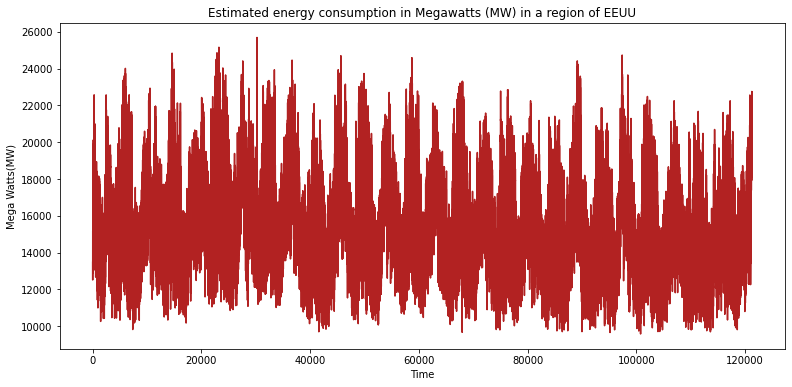

In [4]:
fig, ax = plt.subplots(figsize=(13,6))
ax.plot(data.loc[:, "AEP_MW"], color="firebrick", label="Historical data")
ax.title.set_text('Estimated energy consumption in Megawatts (MW) in a region of EEUU')
ax.set_xlabel("Time")
ax.set_ylabel("Mega Watts(MW)")

### MAPE function

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): #This is the function used to measure every method.
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Neural network

In [6]:
train = array(data_used.loc[:950, "AEP_MW"])
test = array(data_used.loc[950:, "AEP_MW"])
train2 = data_used.loc[:950, :]
test2 = data_used.loc[950:, :]
 
scaler = MinMaxScaler() 
scaled_train = scaler.fit_transform(train.reshape(-1, 1))
scaled_test = scaler.fit_transform(test.reshape(-1, 1))

In [7]:
n_input=25
n_features=1
 
train_generator=TimeseriesGenerator(scaled_train,
                                     scaled_train,
                                      n_input,
                                      batch_size=1)

In [8]:
inputs = Input(shape=(n_input, n_features))
L1 = LSTM(16, activation='relu', return_sequences=True)(inputs) #The model is composed by 2 layers of LSTM neurons.
L4 = LSTM(8, activation='relu')(L1)
output = Dense(1)(L4)

In [9]:
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 25, 16)            1152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epochs = 30
batch_size = 4
 
history = model.fit(train_generator, epochs=nb_epochs, batch_size=batch_size)

In [11]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
 
for i in range(len(test)):
  pred = model.predict(current_batch)[0]
  test_predictions.append(pred)
  current_batch = np.append(current_batch[:,1:,:],[[pred]], axis=1) #Here it is obtained the predictions

In [176]:
prediction_rnn = [test_predictions[i][0] for i in range(len(test_predictions))]
prediction_rnn = scaler.inverse_transform(array(prediction_rnn).reshape(-1, 1))
prediction_rnn = pd.DataFrame(prediction_rnn, columns=["AEP_MW"], index=test2.index.values)

In [13]:
mape_rnn = mean_absolute_percentage_error(list(test2["AEP_MW"]), prediction_rnn["AEP_MW"])
print('Test MAPE: %.3f ' % mape_rnn)

Test MAPE: 5.069 


### Prophet

In [14]:
split_index = 950
train_prop = data_used.loc[data_used.index <= split_index].copy()
test_prop = data_used.loc[data_used.index > split_index].copy()

In [15]:
m = Prophet() #The model was used with default parameters
model_fitted = m.fit(train_prop.reset_index().rename(columns={'Datetime':'ds','AEP_MW':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [177]:
test_predict = model_fitted.predict(df=test_prop.reset_index().rename(columns={'Datetime':'ds'}), )

In [178]:
prediction_prophet = pd.DataFrame(list(test_predict["yhat"]), columns=["AEP_MW"], index=test_prop.index.values)

In [18]:
mape_prop = mean_absolute_percentage_error(list(test_prop["AEP_MW"]), list(prediction_prophet["AEP_MW"]))
print('Test MAPE: %.3f ' % mape_prop)

Test MAPE: 24.675 


### XGBoost

In [19]:
data_used = data_used[["AEP_MW"]].copy()
data_used = data_used.rename(columns={"AEP_MW": "x"})
data_used["y"] = data_used.x.shift(-1)
data_used.dropna(inplace=True)

In [20]:
x_train_xg = array(data_used.loc[0:950, "x"])
y_train_xg = array(data_used.loc[0:950, "y"])
x_test_xg = array(data_used.loc[950:, "x"])
y_test_xg = array(data_used.loc[950:, "y"])

In [21]:
def create_sequences(X, time_steps=1): #Its is the function to create the necessary time-steps to predict and compare with test data
    Xs = []
    for i in range(len(X)-time_steps):
        Xs.append(X[i:(i+time_steps)])
    return np.array(Xs)

In [22]:
x_train_xg = create_sequences(x_train_xg, 48)
y_train_xg = create_sequences(y_train_xg, 48)
x_test_xg = create_sequences(x_test_xg, 48)
y_test_xg = create_sequences(y_test_xg, 48)

In [23]:
model_fitted_xg = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror',  #MultiOutPutRegressor allows a machine learning method to be feed with 
                                            n_estimators=200, learning_rate=0.1,       #multiple time-steps.
                                            subsample=0.6)).fit(x_train_xg, y_train_xg)

In [179]:
prediction_xg = model_fitted_xg.predict(x_train_xg[[-1]])

In [25]:
mape_xg = mean_absolute_percentage_error(y_test_xg, prediction_xg)
print('Test MAPE: %.3f ' % mape_xg)

Test MAPE: 9.836 


In [180]:
prediction_xg = pd.DataFrame(prediction_xg.reshape(48, 1), columns=["AEP_MW"], index=test2.index.values[:-2])

### Results

In [ ]:
prediction_rnn = prediction_rnn.loc[950:997]
prediction_prophet = prediction_prophet.loc[951:998]
prediction_prophet.index = range(950, 998)

In [ ]:
data = pd.read_csv("route/AEP_hourly.csv", sep=",")
data_used = data.loc[22001:23000, :]
data_used = data_used.iloc[::-1]
data_used = data_used.reset_index()

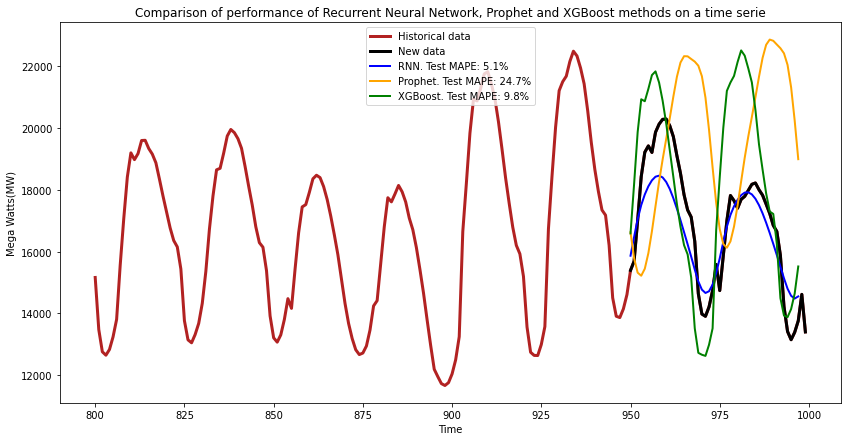

In [188]:
#The plot shows just the last time-steps in order to appreciate the behavior of the predictions.
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(data_used.loc[800:, "AEP_MW"], color="firebrick", label="Historical data",  linewidth=3)
ax.plot(test2.loc[800:, "AEP_MW"], color="black", label="New data", linewidth=3)
ax.plot(prediction_rnn.loc[800:, "AEP_MW"], color="blue", label="RNN. Test MAPE: {}%".format(round(mape_rnn, 1)), linewidth=2)
ax.plot(prediction_prophet.loc[800:, "AEP_MW"], color="orange", label="Prophet. Test MAPE: {}%".format(round(mape_prop, 1)), linewidth=2)
ax.plot(prediction_xg.loc[800:, "AEP_MW"], color="green", label="XGBoost. Test MAPE: {}%".format(round(mape_xg, 1)), linewidth=2)
ax.title.set_text('Comparison of performance of Recurrent Neural Network, Prophet and XGBoost methods on a time serie')
ax.set_xlabel("Time")
ax.set_ylabel("Mega Watts(MW)")
plt.legend(loc=9)
plt.show()

### Conclusions
* Commonly RNN requires a lot of data to work well, although in this case it was fed with 950 samples, it showed to be the best method to predict according to the MAPE.
* Despite the performance of the RNN, it took a lot of time to train, so before taking in account this method it is necessary to think in the computational capacity we have.
* Regarding to the time and the performance, XGBoost demostrated to be the best method to predict because it performed well with a MAPE of 9.8% in just few seconds.
* Prophet made its work trying to follow the additive seasonal behavior, however, it was not enough to perform well on test data.

### References


[1] TensorFlow. 2021. Time series forecasting  |  TensorFlow Core. [online] Available at: <https://www.tensorflow.org/tutorials/structured_data/time_series>[Accessed 18 March 2021].  
                                                                              [2] Prophet. 2021. Prophet. [online] Available at: <https://facebook.github.io/prophet/>[Accessed 18 March 2021].

[3] Xgboost.readthedocs.io. 2021. XGBoost Documentation — xgboost 1.4.0-SNAPSHOT documentation. [online] Available at: <https://xgboost.readthedocs.io/en/latest/>[Accessed 18 March 2021].
